In [12]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy
from torchsummary import summary

In [2]:
# Define device for torch
device = torch.device("cpu")
# MPS for Apple Silicon GPUs
if torch.mps.is_available():
   print("MPS is available")
   device = torch.device("mps")

# CUDA for Nvidia GPUs
if torch.cuda.is_available():
   print("CUDA is available")
   device = torch.device("cuda")
print(device)

MPS is available
mps


## Script to conduct further data cleaning for NN

In [4]:
from sklearn.preprocessing import StandardScaler
import joblib

def feature_engineer(df):
   """Drops the 'date' column from the given dataframe."""
   if 'date' in df.columns:
      df = df.drop(columns=['date'])

   return df
   

train_df = feature_engineer(pd.read_csv("data/train_data_w_macro.csv"))
test_df = feature_engineer(pd.read_csv("data/test_data_w_macro.csv"))
valid_df = feature_engineer(pd.read_csv("data/valid_data_w_macro.csv"))

to_normalize = [
    "lease_months_left", 
    "gdp in chained (2015) dollars", 
    "assets", 
    "liabilities", 
    "mas core inflation measure"
]
# Feature normalization
feature_scaler = StandardScaler()
train_df[to_normalize] = feature_scaler.fit_transform(train_df[to_normalize])
valid_df[to_normalize] = feature_scaler.transform(valid_df[to_normalize])
test_df[to_normalize] = feature_scaler.transform(test_df[to_normalize])

# Target normalization
target_scaler = StandardScaler()
train_df["resale_price"] = target_scaler.fit_transform(train_df[["resale_price"]])
valid_df["resale_price"] = target_scaler.transform(valid_df[["resale_price"]])
test_df["resale_price"] = target_scaler.transform(test_df[["resale_price"]])

# Store scalers for later
joblib.dump(feature_scaler, "scalers/feature_scaler.pkl")
joblib.dump(target_scaler, "scalers/target_scaler.pkl")


['scalers/target_scaler.pkl']

In [5]:
train_df.info()
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)


in_features = train_df.shape[1]-1
print(in_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157062 entries, 0 to 157061
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   storey_range                   157062 non-null  float64
 1   floor_area_sqm                 157062 non-null  float64
 2   lease_months_left              157062 non-null  float64
 3   resale_price                   157062 non-null  float64
 4   gdp in chained (2015) dollars  157062 non-null  float64
 5   assets                         157062 non-null  float64
 6   liabilities                    157062 non-null  float64
 7   mas core inflation measure     157062 non-null  float64
 8   m_from2017                     157062 non-null  float64
 9   town_tampines                  157062 non-null  int64  
 10  town_punggol                   157062 non-null  int64  
 11  town_sembawang                 157062 non-null  int64  
 12  town_choa chu kang            

In [6]:
display(train_df)

,storey_range,floor_area_sqm,lease_months_left,resale_price,gdp in chained (2015) dollars,assets,liabilities,mas core inflation measure,m_from2017,town_tampines,town_punggol,town_sembawang,town_choa chu kang,town_sengkang,flat_model_Apartment,flat_model_DBSS,flat_model_Maisonette
0,0.0000,0.287736,1.443622,0.684373,0.522848,0.457859,0.829841,0.280707,0.684211,0,0,0,0,0,0,0,0
1,0.0000,0.273585,-0.714364,-0.283156,1.394325,1.219070,1.005790,1.311822,0.852632,0,0,0,0,0,0,0,0
2,0.5625,0.287736,1.348765,1.578145,1.722337,1.615420,1.689993,1.786185,0.957895,0,0,0,0,0,0,0,0
3,0.2500,0.278302,0.749984,-0.946926,-0.756953,-1.112826,-0.403701,-0.779763,0.210526,0,0,1,0,0,0,0,0
4,0.2500,0.075472,1.206480,-1.453191,-0.019800,0.115599,0.145449,-0.545516,0.568421,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157057,0.0625,0.264151,1.319123,2.248170,0.384571,0.376178,0.610203,-0.159215,0.631579,0,0,0,0,0,0,0,0
157058,0.0625,0.160377,-1.550287,-1.284436,-0.019800,0.115599,0.145449,-0.498158,0.578947,0,0,0,0,0,0,0,0
157059,0.1875,0.169811,1.153124,-0.159402,0.935297,0.665845,0.732957,0.780119,0.747368,0,1,0,0,0,0,0,0
157060,0.3125,0.339623,-0.091868,0.476242,1.394325,1.219070,1.005790,1.474835,0.873684,0,0,0,0,0,0,0,0


# Define our Dataset object and Dataloaders

In [7]:
class HDBDataset(Dataset):
    def __init__(self, dataframe):
        dataframe = dataframe.reset_index(drop=True)  # Important
        self.features = dataframe.drop(columns=dataframe.columns[3]).to_numpy(dtype=np.float32)
        self.targets = dataframe.iloc[:, 3].to_numpy(dtype=np.float32)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        features = torch.from_numpy(self.features[idx])
        target = torch.tensor(self.targets[idx])
        return features, target


In [8]:
batch_size = 512

train_dataset = HDBDataset(train_df)
valid_dataset = HDBDataset(valid_df)
test_dataset = HDBDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle= False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle= False)

# Multilayer Perceptron (simple_nn)

## Creating simple_nn

In [9]:
# New model to train

class HDBPricePredictor2(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.input = nn.Linear(in_features, 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.fc = nn.Linear(64, 1)

        # Activation functions
        self.activation = nn.LeakyReLU(0.01)  # More stable than ReLU

        # Normalization & Dropout
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(0.1)  # Light dropout

        # Use Huber Loss instead of MSE
        self.loss = nn.L1Loss()

        # Initialize weights
        self._init_weights()

    def forward(self, x):
        x = self.input(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.hidden3(x)
        x = self.bn4(x)
        x = self.activation(x)

        x = self.fc(x)
        return x

    def _init_weights(self):
        for layer in [self.input, self.hidden1, self.hidden2, self.hidden3, self.fc]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
            nn.init.constant_(layer.bias, 0)



In [13]:
model = HDBPricePredictor2(16).to("cpu") 

# Summarize the model
summary(model, input_size=(16,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           8,704
       BatchNorm1d-2                  [-1, 512]           1,024
         LeakyReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5                  [-1, 256]             512
         LeakyReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
       BatchNorm1d-9                  [-1, 128]             256
        LeakyReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
      BatchNorm1d-13                   [-1, 64]             128
        LeakyReLU-14                   

In [118]:
# 1. Create Neural Network model
model = HDBPricePredictor2(in_features).to(device)

# 2. Gradient descent parameters
num_epochs = 130
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.0005,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0.001)

optimizer.zero_grad()

# 3. Loss function
criterion = nn.SmoothL1Loss()

# 4. Early Stopping Setup
import numpy as np
best_val_loss = np.inf
patience = 10
counter = 0
best_model_path = 'updated_nn_weights/best_simple_nn.pth'

# 5. Storage
train_losses = []
val_losses = []

# 6. Training loop
for epoch in range(num_epochs):
    model.train()
    batch_train_losses = []

    for batch in train_loader:
        inputs_batch, outputs_batch = batch
        inputs_re = inputs_batch.to(device)
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        
        optimizer.zero_grad()
        preds = model(inputs_re)
        loss_value = criterion(preds.float(), outputs_re.float())
        loss_value.backward()
        optimizer.step()
        
        batch_train_losses.append(loss_value.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            inputs_re = inputs_batch.to(device)
            outputs_re = outputs_batch.to(device).reshape(-1, 1)

            preds = model(inputs_re)
            val_loss = criterion(preds.float(), outputs_re.float())
            batch_val_losses.append(val_loss.item())

    val_loss = sum(batch_val_losses) / len(batch_val_losses)
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping and saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved Best Model at Epoch {epoch+1} with Val Loss {val_loss:.6f}")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
            break


Epoch [1/130] - Train Loss: 0.1548 | Val Loss: 0.1118
Saved Best Model at Epoch 1 with Val Loss 0.111844
Epoch [2/130] - Train Loss: 0.1214 | Val Loss: 0.1124
Epoch [3/130] - Train Loss: 0.1170 | Val Loss: 0.1093
Saved Best Model at Epoch 3 with Val Loss 0.109278
Epoch [4/130] - Train Loss: 0.1154 | Val Loss: 0.1073
Saved Best Model at Epoch 4 with Val Loss 0.107263
Epoch [5/130] - Train Loss: 0.1131 | Val Loss: 0.1077
Epoch [6/130] - Train Loss: 0.1122 | Val Loss: 0.1041
Saved Best Model at Epoch 6 with Val Loss 0.104127
Epoch [7/130] - Train Loss: 0.1108 | Val Loss: 0.1038
Saved Best Model at Epoch 7 with Val Loss 0.103811
Epoch [8/130] - Train Loss: 0.1091 | Val Loss: 0.1046
Epoch [9/130] - Train Loss: 0.1087 | Val Loss: 0.1055
Epoch [10/130] - Train Loss: 0.1082 | Val Loss: 0.1060
Epoch [11/130] - Train Loss: 0.1076 | Val Loss: 0.1000
Saved Best Model at Epoch 11 with Val Loss 0.100038
Epoch [12/130] - Train Loss: 0.1067 | Val Loss: 0.1024
Epoch [13/130] - Train Loss: 0.1060 | Val 

## Assessing simple_nn

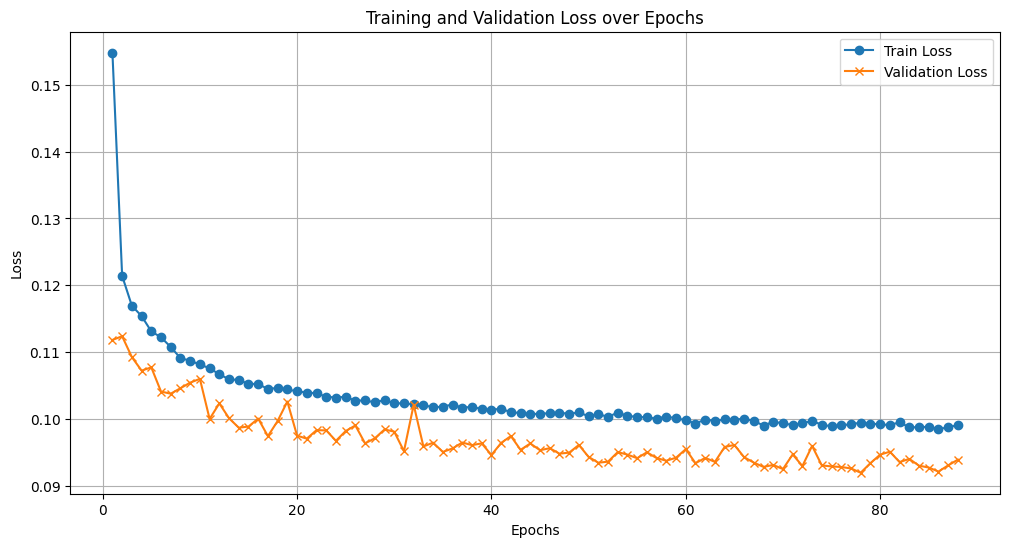

In [119]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x') 
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [120]:
print(train_losses)

[0.15477336654348559, 0.12141999468838353, 0.11695687528638964, 0.11541190733738753, 0.11312512065669224, 0.11223382386303103, 0.11079357202841326, 0.1091301946473044, 0.10873569191375851, 0.10817930175155305, 0.10760581452120399, 0.10671931056226892, 0.10595755356724953, 0.10585984364394645, 0.10527692650253688, 0.10526367852082082, 0.10450440387966578, 0.10467879236326932, 0.1044376037456702, 0.10416502457002863, 0.10397764508906715, 0.10388575882593273, 0.10336245147432489, 0.10322643869862883, 0.10334700629940251, 0.10274672860140133, 0.10282204635077269, 0.10250078071309224, 0.10286113214512213, 0.10238031887658644, 0.10235659753849141, 0.10223504078213477, 0.10212103510427165, 0.10176009298924125, 0.10189035532431805, 0.10218688547125857, 0.10173290885426711, 0.10182264029785554, 0.10152090241349869, 0.10139000073609213, 0.101580429810072, 0.1010186933830429, 0.10093517438887774, 0.10080501240608358, 0.10077515642495419, 0.10091729753374665, 0.10096535445812858, 0.100802180384580

In [121]:
# 1. Reload model architecture
model = HDBPricePredictor2(in_features).to(device)

# 2. Load the saved weights
model.load_state_dict(torch.load('updated_nn_weights/best_simple_nn.pth')) 
model.eval()  

test_losses = []
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)  # normalized resale prices
        inputs_re = inputs_batch.to(device)

        # 3. Forward pass
        test_pred = model(inputs_re)

        # 4. Compute loss (still in normalized space)
        loss = model.loss(test_pred.float(), outputs_re.float())
        test_losses.append(loss.item())

        # 5. Save preds and targets for later (to de-normalize and check real values)
        all_preds.append(test_pred.cpu())
        all_targets.append(outputs_re.cpu())

# 6. Calculate avg test loss (normalized)
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss (normalized): {avg_test_loss:.4f}')

# 7. De-normalize predictions and targets to get real SGD prices

# Load feature scaler
feature_scaler = joblib.load('scalers/feature_scaler.pkl')
# Load target scaler (for resale price)
target_scaler = joblib.load('scalers/target_scaler.pkl')

all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

all_preds_real = target_scaler.inverse_transform(all_preds)
all_targets_real = target_scaler.inverse_transform(all_targets)

# 8. Optional: Real world evaluation (e.g., MAE, RMSE)
real_loss = np.mean(np.abs(all_preds_real - all_targets_real))
print(f'Test Mean Absolute Error (SGD): {real_loss:,.2f}')


Test Loss (normalized): 0.2964
Test Mean Absolute Error (SGD): 52,580.13


In [122]:
# Select an index
sample_idx = 380  # Change this to pick different samples
sample_features, sample_target = test_dataset[sample_idx]

# Move to device
sample_features = sample_features.to(device).unsqueeze(0)  # Add batch dimension (1, num_features)
sample_target = sample_target.unsqueeze(0)  # Make it (1,) shape to match scaling

# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    predicted_price = model(sample_features).cpu().numpy()  # (1,1) numpy array

# De-normalize both
predicted_price_real = target_scaler.inverse_transform(predicted_price)[0][0]
actual_price_real = target_scaler.inverse_transform(sample_target.cpu().numpy().reshape(-1, 1))[0][0]

print(f"Actual Resale Price: {actual_price_real:,.2f} SGD")
print(f"Predicted Resale Price: {predicted_price_real:,.2f} SGD")


Actual Resale Price: 403,000.00 SGD
Predicted Resale Price: 378,644.50 SGD


# Tabular Resnet

## Creating tabular_resnet

In [123]:
import torch
import torch.nn as nn

class TabularResNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc_out = nn.Linear(128, 1)

        self.dropout = nn.Dropout(0.2)
        self.act = nn.ReLU()

    def forward(self, x):
        # Input Layer
        x = self.act(self.bn1(self.fc1(x)))

        # Residual Block
        residual = x
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x += residual  # Skip connection

        # Final Layers
        x = self.act(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        out = self.fc_out(x)
        return out


In [124]:
model = TabularResNet(in_features).to(device)
criterion = nn.SmoothL1Loss()  # Huber Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [125]:
best_val_loss = np.inf
patience = 10
counter = 0
best_model_path = 'updated_nn_weights/best_tabular_resnet.pth'

In [126]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    batch_train_losses = []

    for batch in train_loader:
        inputs_batch, outputs_batch = batch
        inputs_batch = inputs_batch.to(device)
        outputs_batch = outputs_batch.to(device).reshape(-1, 1)

        optimizer.zero_grad()
        preds = model(inputs_batch)
        loss = criterion(preds, outputs_batch)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            inputs_batch = inputs_batch.to(device)
            outputs_batch = outputs_batch.to(device).reshape(-1, 1)

            preds = model(inputs_batch)
            val_loss = criterion(preds, outputs_batch)
            batch_val_losses.append(val_loss.item())

    val_loss = np.mean(batch_val_losses)
    val_losses.append(val_loss)

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: New best model saved with val loss {val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1: New best model saved with val loss 0.1141
Epoch [1/100] Train Loss: 0.1450 | Val Loss: 0.1141
Epoch 2: New best model saved with val loss 0.1068
Epoch [2/100] Train Loss: 0.1196 | Val Loss: 0.1068
Epoch 3: New best model saved with val loss 0.1056
Epoch [3/100] Train Loss: 0.1158 | Val Loss: 0.1056
Epoch 4: New best model saved with val loss 0.1043
Epoch [4/100] Train Loss: 0.1132 | Val Loss: 0.1043
Epoch [5/100] Train Loss: 0.1123 | Val Loss: 0.1043
Epoch [6/100] Train Loss: 0.1113 | Val Loss: 0.1054
Epoch 7: New best model saved with val loss 0.1028
Epoch [7/100] Train Loss: 0.1106 | Val Loss: 0.1028
Epoch [8/100] Train Loss: 0.1098 | Val Loss: 0.1040
Epoch [9/100] Train Loss: 0.1092 | Val Loss: 0.1028
Epoch 10: New best model saved with val loss 0.1013
Epoch [10/100] Train Loss: 0.1087 | Val Loss: 0.1013
Epoch 11: New best model saved with val loss 0.1005
Epoch [11/100] Train Loss: 0.1079 | Val Loss: 0.1005
Epoch 12: New best model saved with val loss 0.1004
Epoch [12/100] 

In [127]:
print(train_losses,
val_losses)

[np.float64(0.14503133071264926), np.float64(0.11963669166988193), np.float64(0.11578657694088132), np.float64(0.11319960556705923), np.float64(0.11227244500325635), np.float64(0.11129021530528022), np.float64(0.11061427145225605), np.float64(0.10983619720034957), np.float64(0.10915559610345853), np.float64(0.10866551397289438), np.float64(0.10793731458703547), np.float64(0.1074594339592449), np.float64(0.10690590299981424), np.float64(0.10661512996746585), np.float64(0.10575590316655194), np.float64(0.10586896232945135), np.float64(0.10544646189150671), np.float64(0.10553504215972043), np.float64(0.10460622946000643), np.float64(0.10448299610459455), np.float64(0.1044230884371829), np.float64(0.10430805188533926), np.float64(0.10394475893011311), np.float64(0.10368924665625787), np.float64(0.10314558026553754), np.float64(0.10318211851950966), np.float64(0.10321028625246756), np.float64(0.10300023531001243), np.float64(0.10277402629098985), np.float64(0.10267148812450104), np.float64(

## Assessing tabular_resnet

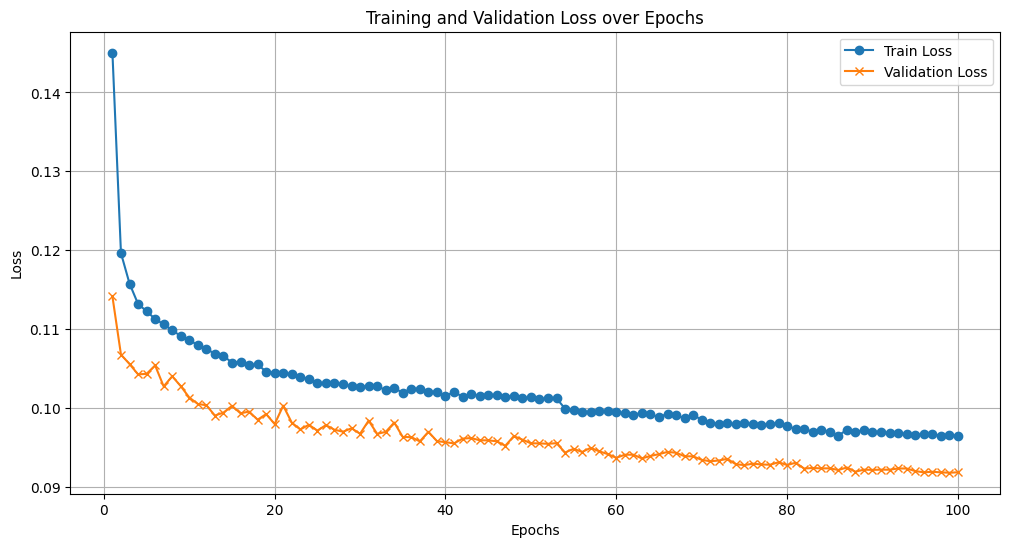

In [128]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='x') 
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [129]:
# 1. Reload your TabularResNet model architecture
model = TabularResNet(in_features).to(device)  
model.load_state_dict(torch.load('updated_nn_weights/best_tabular_resnet.pth'))  # Load best weights
model.eval()  # Important: set to evaluation mode

# 2. Testing Loop
test_losses = []
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs_batch, outputs_batch = batch
        inputs_re = inputs_batch.to(device)
        outputs_re = outputs_batch.to(device).reshape(-1, 1)  # normalized resale prices

        # 3. Forward pass
        test_pred = model(inputs_re)

        # 4. Compute loss (still in normalized space)
        loss = nn.SmoothL1Loss()(test_pred.float(), outputs_re.float())
        test_losses.append(loss.item())

        # 5. Save preds and targets
        all_preds.append(test_pred.cpu())
        all_targets.append(outputs_re.cpu())

# 6. Calculate average test loss (normalized)
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss (normalized): {avg_test_loss:.4f}')

# 7. Load scalers (for de-normalization)
feature_scaler = joblib.load('scalers/feature_scaler.pkl')
target_scaler = joblib.load('scalers/target_scaler.pkl')

# 8. De-normalize predictions and targets
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

all_preds_real = target_scaler.inverse_transform(all_preds)
all_targets_real = target_scaler.inverse_transform(all_targets)

# 9. Evaluate real-world metrics (e.g., MAE)
real_loss = np.mean(np.abs(all_preds_real - all_targets_real))
print(f'Test Mean Absolute Error (SGD): {real_loss:,.2f}')


Test Loss (normalized): 0.0935
Test Mean Absolute Error (SGD): 52,122.70
